# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

### Owner: [Sandeep Aswathnarayana](https://www.linkedin.com/in/sandeep-a/)

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Pipeline Architecture:  
Step 1: Load The Data.  
Step 2: Dataset Summary & Exploration.  
Step 3: Data Preprocessing.  
- Shuffling.
- Grayscaling.
- Local Histogram Equalization.
- Normalization.

Step 4: Design a Model Architecture: Model Training and Evaluation.  
- LeNet-5.  
- VGGNet.  

Step 5: Model Training and Evaluation.  
Step 6: Testing the Model Using the Test Set.  
Step 7: Testing the Model on New Images.  

## Import necessary libraries

In [5]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
import skimage.morphology as morp
from skimage.filters import rank
from sklearn.utils import shuffle
import csv
import os
import tensorflow as tf
from tensorflow.contrib.layers import flatten
from sklearn.metrics import confusion_matrix

# is it using the GPU?
print(tf.test.gpu_device_name())

# Show current TensorFlow version
tf.__version__

/gpu:0


'1.3.0'

---
## Step 1: Load The Data

Download the dataset from [here](). This is a pickled dataset in which we've already resized the images to 32x32.

We already have three .p files of 32x32 resized images:  
- train.p: The training set.  
- test.p: The testing set.  
- valid.p: The validation set.  

We will use Python pickle to load the data.

In [6]:
# Load pickled data
#import pickle

# TODO: Fill this in based on where you saved the training and testing data
training_file = "../data/train.p"
validation_file= "../data/valid.p"
testing_file = "../data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

In [7]:
# Mapping ClassID to traffic sign names
signs = []
with open('signnames.csv', 'r') as csvfile:
    signnames = csv.reader(csvfile, delimiter=',')
    next(signnames,None)
    for row in signnames:
        signs.append(row[1])
    csvfile.close()

---

## Step 2: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

The code snippets below will provide a basic summery of the Dataset.

First, we will use numpy provide the number of images in each subset, in addition to the image size, and the number of unique classes.

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [8]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = X_train.shape[0]

# TODO: Number of validation examples
n_validation = X_valid.shape[0]

# TODO: Number of testing examples.
n_test = X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples:", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples: 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

In [9]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

def list_images(dataset, dataset_y, ylabel="", cmap=None):
    """
    Display a list of images in a single figure with matplotlib.
        Parameters:
            images: An np.array compatible with plt.imshow.
            lanel (Default = No label): A string to be used as a label for each image.
            cmap (Default = None): Used to display gray images.
    """
    plt.figure(figsize=(15, 16))
    for i in range(6):
        plt.subplot(1, 6, i+1)
        indx = random.randint(0, len(dataset))
        #Use gray scale color map if there is only one channel
        cmap = 'gray' if len(dataset[indx].shape) == 2 else cmap
        plt.imshow(dataset[indx], cmap = cmap)
        plt.xlabel(signs[dataset_y[indx]])
        plt.ylabel(ylabel)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()

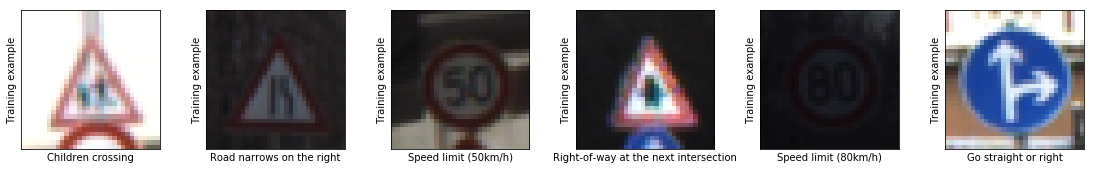

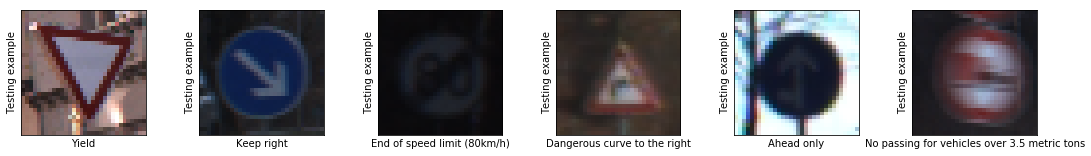

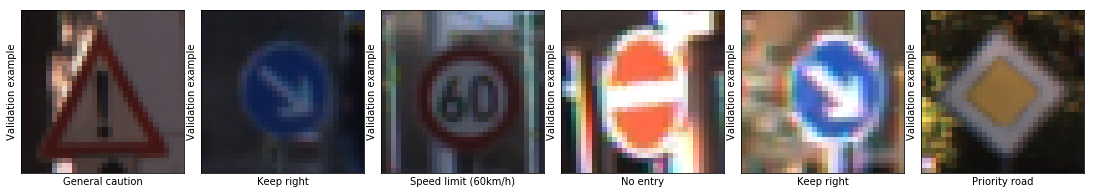

In [10]:
# Plotting sample examples
list_images(X_train, y_train, "Training example")
list_images(X_test, y_test, "Testing example")
list_images(X_valid, y_valid, "Validation example")

#### And finally, we will use numpy to plot a histogram of the count of images in each unique class.

In [11]:
def histogram_plot(dataset, label):
    """
    Plots a histogram of the input data.
        Parameters:
            dataset: Input data to be plotted as a histogram.
            lanel: A string to be used as a label for the histogram.
    """
    hist, bins = np.histogram(dataset, bins=n_classes)
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.bar(center, hist, align='center', width=width)
    plt.xlabel(label)
    plt.ylabel("Image count")
    plt.show()

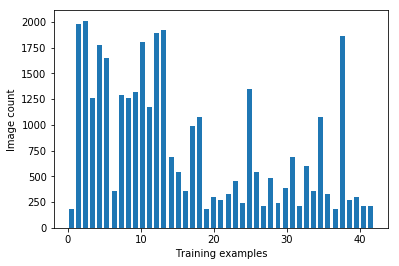

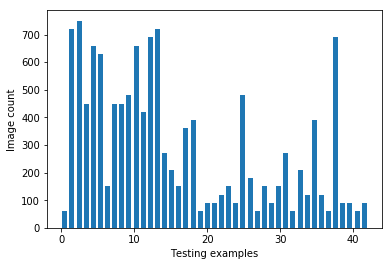

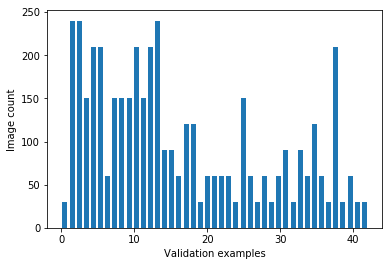

In [12]:
# Plotting histograms of the count of each sign
histogram_plot(y_train, "Training examples")
histogram_plot(y_test, "Testing examples")
histogram_plot(y_valid, "Validation examples")

## Step 3: Data Preprocessing

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.
In this step, we will apply several preprocessing steps to the input images to achieve the best possible results.

We will use the following preprocessing techniques:

1. Shuffling.  
2. Grayscaling.  
3. Local Histogram Equalization.  
4. Normalization.  

1. Shuffling: In general, we shuffle the training data to increase randomness and variety in training dataset, in order for the model to be more stable. We will use sklearn to shuffle our data.

In [13]:
X_train, y_train = shuffle(X_train, y_train)

2. Grayscaling: In their paper "Traffic Sign Recognition with Multi-Scale Convolutional Networks" published in 2011, P. Sermanet and Y. LeCun stated that using grayscale images instead of color improves the ConvNet's accuracy. We will use OpenCV to convert the training images into grey scale.

In [14]:
def gray_scale(image):
    """
    Convert images to gray scale.
        Parameters:
            image: An np.array compatible with plt.imshow.
    """
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

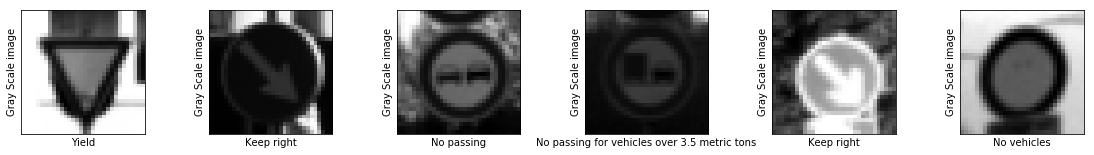

In [15]:
# Sample images after greyscaling
gray_images = list(map(gray_scale, X_train))
list_images(gray_images, y_train, "Gray Scale image", "gray")

3. Local Histogram Equalization: This technique simply spreads out the most frequent intensity values in an image, resulting in enhancing images with low contrast. Applying this technique will be very helpfull in our case since the dataset in hand has real world images, and many of them has low contrast. We will use skimage to apply local histogram equalization to the training images.

In [16]:
def local_histo_equalize(image):
    """
    Apply local histogram equalization to grayscale images.
        Parameters:
            image: A grayscale image.
    """
    kernel = morp.disk(30)
    img_local = rank.equalize(image, selem=kernel)
    return img_local

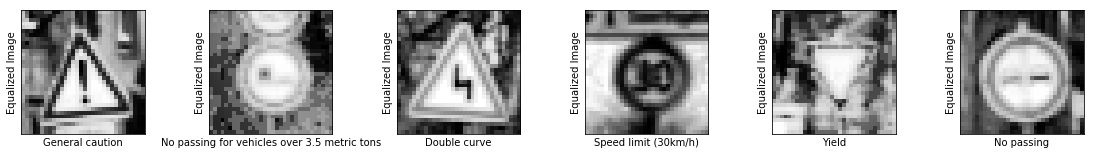

In [17]:
# Sample images after Local Histogram Equalization
equalized_images = list(map(local_histo_equalize, gray_images))
list_images(equalized_images, y_train, "Equalized Image", "gray")

4. Normalization: Normalization is a process that changes the range of pixel intensity values. Usually the image data should be normalized so that the data has mean zero and equal variance.

In [18]:
def image_normalize(image):
    """
    Normalize images to [0, 1] scale.
        Parameters:
            image: An np.array compatible with plt.imshow.
    """
    image = np.divide(image, 255)
    return image

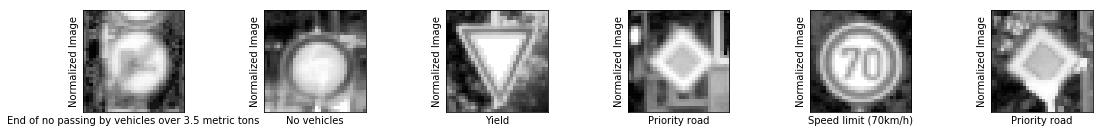

In [19]:
# Sample images after normalization
n_training = X_train.shape
normalized_images = np.zeros((n_training[0], n_training[1], n_training[2]))
for i, img in enumerate(equalized_images):
    normalized_images[i] = image_normalize(img)
list_images(normalized_images, y_train, "Normalized Image", "gray")
normalized_images = normalized_images[..., None]

In [20]:
def preprocess(data):
    """
    Applying the preprocessing steps to the input data.
        Parameters:
            data: An np.array compatible with plt.imshow.
    """
    gray_images = list(map(gray_scale, data))
    equalized_images = list(map(local_histo_equalize, gray_images))
    n_training = data.shape
    normalized_images = np.zeros((n_training[0], n_training[1], n_training[2]))
    for i, img in enumerate(equalized_images):
        normalized_images[i] = image_normalize(img)
    normalized_images = normalized_images[..., None]
    return normalized_images

----

## Step 4: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

In this step, we will design and implement a deep learning model that learns to recognize traffic signs from our dataset German Traffic Sign Dataset.

We'll use Convolutional Neural Networks to classify the images in this dataset. The reason behind choosing ConvNets is that they are designed to recognize visual patterns directly from pixel images with minimal preprocessing. They automatically learn hierarchies of invariant features at every level from data. We will implement two of the most famous ConvNets. Our goal is to reach an accuracy of +95% on the validation set.

I'll start by explaining each network architecture, then implement it using TensorFlow.

Notes:

- We specify the learning rate of 0.001, which tells the network how quickly to update the weights.
- We minimize the loss function using the Adaptive Moment Estimation (Adam) Algorithm. Adam is an optimization algorithm introduced by D. Kingma and J. Lei Ba in a 2015 paper named Adam: A Method for Stochastic Optimization. Adam algorithm computes adaptive learning rates for each parameter. In addition to storing an exponentially decaying average of past squared gradients like Adadelta and RMSprop algorithms, Adam also keeps an exponentially decaying average of past gradients mtmt, similar to momentum algorithm, which in turn produce better results.
- We will run minimize() function on the optimizer which use backprobagation to update the network and minimize our training loss.

1. LeNet-5
LeNet-5 is a convolutional network designed for handwritten and machine-printed character recognition. It was introduced by the famous Yann LeCun in his paper Gradient-Based Learning Applied to Document Recognition in 1998. Although this ConvNet is intended to classify hand-written digits, we're confident it have a very high accuracy when dealing with traffic signs, given that both hand-written digits and traffic signs are given to the computer in the form of pixel images.

LeNet-5 architecture:

This ConvNet follows these steps:

Input => Convolution => ReLU => Pooling => Convolution => ReLU => Pooling => FullyConnected => ReLU => FullyConnected

Layer 1 (Convolutional): The output shape should be 28x28x6.

Activation. Your choice of activation function.

Pooling. The output shape should be 14x14x6.

Layer 2 (Convolutional): The output shape should be 10x10x16.

Activation. Your choice of activation function.

Pooling. The output shape should be 5x5x16.

Flattening: Flatten the output shape of the final pooling layer such that it's 1D instead of 3D.

Layer 3 (Fully Connected): This should have 120 outputs.

Activation. Your choice of activation function.

Layer 4 (Fully Connected): This should have 84 outputs.

Activation. Your choice of activation function.

Layer 5 (Fully Connected): This should have 43 outputs.

In [21]:
class LaNet:  

    def __init__(self, n_out=43, mu=0, sigma=0.1, learning_rate=0.001):
        # Hyperparameters
        self.mu = mu
        self.sigma = sigma

        # Layer 1 (Convolutional): Input = 32x32x1. Output = 28x28x6.
        self.filter1_width = 5
        self.filter1_height = 5
        self.input1_channels = 1
        self.conv1_output = 6
        # Weight and bias
        self.conv1_weight = tf.Variable(tf.truncated_normal(
            shape=(self.filter1_width, self.filter1_height, self.input1_channels, self.conv1_output),
            mean = self.mu, stddev = self.sigma))
        self.conv1_bias = tf.Variable(tf.zeros(self.conv1_output))
        # Apply Convolution
        self.conv1 = tf.nn.conv2d(x, self.conv1_weight, strides=[1, 1, 1, 1], padding='VALID') + self.conv1_bias
                
        # Activation:
        self.conv1 = tf.nn.relu(self.conv1)
        
        # Pooling: Input = 28x28x6. Output = 14x14x6.
        self.conv1 = tf.nn.max_pool(self.conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
        
        # Layer 2 (Convolutional): Output = 10x10x16.
        self.filter2_width = 5
        self.filter2_height = 5
        self.input2_channels = 6
        self.conv2_output = 16
        # Weight and bias
        self.conv2_weight = tf.Variable(tf.truncated_normal(
            shape=(self.filter2_width, self.filter2_height, self.input2_channels, self.conv2_output),
            mean = self.mu, stddev = self.sigma))
        self.conv2_bias = tf.Variable(tf.zeros(self.conv2_output))
        # Apply Convolution
        self.conv2 = tf.nn.conv2d(self.conv1, self.conv2_weight, strides=[1, 1, 1, 1], padding='VALID') + self.conv2_bias
                
        # Activation:
        self.conv2 = tf.nn.relu(self.conv2)
        
        # Pooling: Input = 10x10x16. Output = 5x5x16.
        self.conv2 = tf.nn.max_pool(self.conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
        
        # Flattening: Input = 5x5x16. Output = 400.
        self.fully_connected0 = flatten(self.conv2)
        
        # Layer 3 (Fully Connected): Input = 400. Output = 120.
        self.connected1_weights = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = self.mu, stddev = self.sigma))
        self.connected1_bias = tf.Variable(tf.zeros(120))
        self.fully_connected1 = tf.add((tf.matmul(self.fully_connected0, self.connected1_weights)), self.connected1_bias)
        
        # Activation:
        self.fully_connected1 = tf.nn.relu(self.fully_connected1)
    
        # Layer 4 (Fully Connected): Input = 120. Output = 84.
        self.connected2_weights = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = self.mu, stddev = self.sigma))
        self.connected2_bias = tf.Variable(tf.zeros(84))
        self.fully_connected2 = tf.add((tf.matmul(self.fully_connected1, self.connected2_weights)), self.connected2_bias)
                
        # Activation.
        self.fully_connected2 = tf.nn.relu(self.fully_connected2)
    
        # Layer 5 (Fully Connected): Input = 84. Output = 43.
        self.output_weights = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = self.mu, stddev = self.sigma))
        self.output_bias = tf.Variable(tf.zeros(43))
        self.logits =  tf.add((tf.matmul(self.fully_connected2, self.output_weights)), self.output_bias)

        # Training operation
        self.one_hot_y = tf.one_hot(y, n_out)
        self.cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=self.logits, labels=self.one_hot_y)
        self.loss_operation = tf.reduce_mean(self.cross_entropy)
        self.optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
        self.training_operation = self.optimizer.minimize(self.loss_operation)

        # Accuracy operation
        self.correct_prediction = tf.equal(tf.argmax(self.logits, 1), tf.argmax(self.one_hot_y, 1))
        self.accuracy_operation = tf.reduce_mean(tf.cast(self.correct_prediction, tf.float32))

        # Saving all variables
        self.saver = tf.train.Saver()
            
    def y_predict(self, X_data, BATCH_SIZE=64):
        num_examples = len(X_data)
        y_pred = np.zeros(num_examples, dtype=np.int32)
        sess = tf.get_default_session()
        for offset in range(0, num_examples, BATCH_SIZE):
            batch_x = X_data[offset:offset+BATCH_SIZE]
            y_pred[offset:offset+BATCH_SIZE] = sess.run(tf.argmax(self.logits, 1), 
                               feed_dict={x:batch_x, keep_prob:1, keep_prob_conv:1})
        return y_pred
    
    def evaluate(self, X_data, y_data, BATCH_SIZE=64):
        num_examples = len(X_data)
        total_accuracy = 0
        sess = tf.get_default_session()
        for offset in range(0, num_examples, BATCH_SIZE):
            batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
            accuracy = sess.run(self.accuracy_operation, 
                                feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0, keep_prob_conv: 1.0 })
            total_accuracy += (accuracy * len(batch_x))
        return total_accuracy / num_examples

2. VGGNet
VGGNet was first introduced in 2014 by K. Simonyan and A. Zisserman from the University of Oxford in a paper called Very Deep Convolutional Networks for Large-Scale Image Recognition. They were investigating the convolutional network depth on its accuracy in the large-scale image recognition setting. Their main contribution is a thorough evaluation of networks of increasing depth using an architecture with very small (3x3) convolution filters, which shows that a significant improvement on the prior-art configurations can be achieved by pushing the depth to 16-19 weight layers.

VGGNet architecture:

The original VGGNet architecture has 16-19 layers, but I've excluded some of them and implemented a modified version of only 12 layers to save computational resources.

This ConvNet follows these steps:

Input => Convolution => ReLU => Convolution => ReLU => Pooling => Convolution => ReLU => Convolution => ReLU => Pooling => Convolution => ReLU => Convolution => ReLU => Pooling => FullyConnected => ReLU => FullyConnected => ReLU => FullyConnected

Layer 1 (Convolutional): The output shape should be 32x32x32.

Activation. Your choice of activation function.

Layer 2 (Convolutional): The output shape should be 32x32x32.

Activation. Your choice of activation function.

Layer 3 (Pooling) The output shape should be 16x16x32.

Layer 4 (Convolutional): The output shape should be 16x16x64.

Activation. Your choice of activation function.

Layer 5 (Convolutional): The output shape should be 16x16x64.

Activation. Your choice of activation function.

Layer 6 (Pooling) The output shape should be 8x8x64.

Layer 7 (Convolutional): The output shape should be 8x8x128.

Activation. Your choice of activation function.

Layer 8 (Convolutional): The output shape should be 8x8x128.

Activation. Your choice of activation function.

Layer 9 (Pooling) The output shape should be 4x4x128.

Flattening: Flatten the output shape of the final pooling layer such that it's 1D instead of 3D.

Layer 10 (Fully Connected): This should have 128 outputs.

Activation. Your choice of activation function.

Layer 11 (Fully Connected): This should have 128 outputs.

Activation. Your choice of activation function.

Layer 12 (Fully Connected): This should have 43 outputs.

In [22]:
class VGGnet:  

    def __init__(self, n_out=43, mu=0, sigma=0.1, learning_rate=0.001):
        # Hyperparameters
        self.mu = mu
        self.sigma = sigma

        # Layer 1 (Convolutional): Input = 32x32x1. Output = 32x32x32.
        self.conv1_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 1, 32), mean = self.mu, stddev = self.sigma))
        self.conv1_b = tf.Variable(tf.zeros(32))
        self.conv1   = tf.nn.conv2d(x, self.conv1_W, strides=[1, 1, 1, 1], padding='SAME') + self.conv1_b

        # ReLu Activation.
        self.conv1 = tf.nn.relu(self.conv1)

        # Layer 2 (Convolutional): Input = 32x32x32. Output = 32x32x32.
        self.conv2_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 32, 32), mean = self.mu, stddev = self.sigma))
        self.conv2_b = tf.Variable(tf.zeros(32))
        self.conv2   = tf.nn.conv2d(self.conv1, self.conv2_W, strides=[1, 1, 1, 1], padding='SAME') + self.conv2_b
        
        # ReLu Activation.
        self.conv2 = tf.nn.relu(self.conv2)

        # Layer 3 (Pooling): Input = 32x32x32. Output = 16x16x32.
        self.conv2 = tf.nn.max_pool(self.conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
        self.conv2 = tf.nn.dropout(self.conv2, keep_prob_conv)

        # Layer 4 (Convolutional): Input = 16x16x32. Output = 16x16x64.
        self.conv3_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 32, 64), mean = self.mu, stddev = self.sigma))
        self.conv3_b = tf.Variable(tf.zeros(64))
        self.conv3   = tf.nn.conv2d(self.conv2, self.conv3_W, strides=[1, 1, 1, 1], padding='SAME') + self.conv3_b

        # ReLu Activation.
        self.conv3 = tf.nn.relu(self.conv3)

        # Layer 5 (Convolutional): Input = 16x16x64. Output = 16x16x64.
        self.conv4_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 64, 64), mean = self.mu, stddev = self.sigma))
        self.conv4_b = tf.Variable(tf.zeros(64))
        self.conv4   = tf.nn.conv2d(self.conv3, self.conv4_W, strides=[1, 1, 1, 1], padding='SAME') + self.conv4_b
        
        # ReLu Activation.
        self.conv4 = tf.nn.relu(self.conv4)

        # Layer 6 (Pooling): Input = 16x16x64. Output = 8x8x64.
        self.conv4 = tf.nn.max_pool(self.conv4, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
        self.conv4 = tf.nn.dropout(self.conv4, keep_prob_conv) # dropout

        # Layer 7 (Convolutional): Input = 8x8x64. Output = 8x8x128.
        self.conv5_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 64, 128), mean = self.mu, stddev = self.sigma))
        self.conv5_b = tf.Variable(tf.zeros(128))
        self.conv5   = tf.nn.conv2d(self.conv4, self.conv5_W, strides=[1, 1, 1, 1], padding='SAME') + self.conv5_b

        # ReLu Activation.
        self.conv5 = tf.nn.relu(self.conv5)

        # Layer 8 (Convolutional): Input = 8x8x128. Output = 8x8x128.
        self.conv6_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 128, 128), mean = self.mu, stddev = self.sigma))
        self.conv6_b = tf.Variable(tf.zeros(128))
        self.conv6   = tf.nn.conv2d(self.conv5, self.conv6_W, strides=[1, 1, 1, 1], padding='SAME') + self.conv6_b

        # ReLu Activation.
        self.conv6 = tf.nn.relu(self.conv6)

        # Layer 9 (Pooling): Input = 8x8x128. Output = 4x4x128.
        self.conv6 = tf.nn.max_pool(self.conv6, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
        self.conv6 = tf.nn.dropout(self.conv6, keep_prob_conv) # dropout

        # Flatten. Input = 4x4x128. Output = 2048.
        self.fc0   = flatten(self.conv6)
        
        # Layer 10 (Fully Connected): Input = 2048. Output = 128.
        self.fc1_W = tf.Variable(tf.truncated_normal(shape=(2048, 128), mean = self.mu, stddev = self.sigma))
        self.fc1_b = tf.Variable(tf.zeros(128))
        self.fc1   = tf.matmul(self.fc0, self.fc1_W) + self.fc1_b

        # ReLu Activation.
        self.fc1    = tf.nn.relu(self.fc1)
        self.fc1    = tf.nn.dropout(self.fc1, keep_prob) # dropout

        # Layer 11 (Fully Connected): Input = 128. Output = 128.
        self.fc2_W  = tf.Variable(tf.truncated_normal(shape=(128, 128), mean = self.mu, stddev = self.sigma))
        self.fc2_b  = tf.Variable(tf.zeros(128))
        self.fc2    = tf.matmul(self.fc1, self.fc2_W) + self.fc2_b

        # ReLu Activation.
        self.fc2    = tf.nn.relu(self.fc2)
        self.fc2    = tf.nn.dropout(self.fc2, keep_prob) # dropout

        # Layer 12 (Fully Connected): Input = 128. Output = n_out.
        self.fc3_W  = tf.Variable(tf.truncated_normal(shape=(128, n_out), mean = self.mu, stddev = self.sigma))
        self.fc3_b  = tf.Variable(tf.zeros(n_out))
        self.logits = tf.matmul(self.fc2, self.fc3_W) + self.fc3_b

        # Training operation
        self.one_hot_y = tf.one_hot(y, n_out)
        self.cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=self.logits, labels=self.one_hot_y)
        self.loss_operation = tf.reduce_mean(self.cross_entropy)
        self.optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
        self.training_operation = self.optimizer.minimize(self.loss_operation)
        
        # Accuracy operation
        self.correct_prediction = tf.equal(tf.argmax(self.logits, 1), tf.argmax(self.one_hot_y, 1))
        self.accuracy_operation = tf.reduce_mean(tf.cast(self.correct_prediction, tf.float32))

        # Saving all variables
        self.saver = tf.train.Saver()
        
    def y_predict(self, X_data, BATCH_SIZE=64):
        num_examples = len(X_data)
        y_pred = np.zeros(num_examples, dtype=np.int32)
        sess = tf.get_default_session()
        for offset in range(0, num_examples, BATCH_SIZE):
            batch_x = X_data[offset:offset+BATCH_SIZE]
            y_pred[offset:offset+BATCH_SIZE] = sess.run(tf.argmax(self.logits, 1), 
                               feed_dict={x:batch_x, keep_prob:1, keep_prob_conv:1})
        return y_pred
    
    def evaluate(self, X_data, y_data, BATCH_SIZE=64):
        num_examples = len(X_data)
        total_accuracy = 0
        sess = tf.get_default_session()
        for offset in range(0, num_examples, BATCH_SIZE):
            batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
            accuracy = sess.run(self.accuracy_operation, 
                                feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0, keep_prob_conv: 1.0 })
            total_accuracy += (accuracy * len(batch_x))
        return total_accuracy / num_examples
    

## Step 4: Model Architecture: Model Training and Evaluation

In this step, we will train our model using normalized_images, then we'll compute softmax cross entropy between logits and labels to measure the model's error probability.

x is a placeholder for a batch of input images. y is a placeholder for a batch of output labels.

In [23]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))

The keep_prob and keep_prob_conv variables will be used to control the dropout rate when training the neural network. Overfitting is a serious problem in deep nural networks. Dropout is a technique for addressing this problem. The key idea is to randomly drop units (along with their connections) from the neural network during training. This prevents units from co-adapting too much. During training, dropout samples from an exponential number of different “thinned” networks. At test time, it is easy to approximate the effect of averaging the predictions of all these thinned networks by simply using a single unthinned network that has smaller weights. This significantly reduces overfitting and gives major improvements over other regularization methods. This technique was introduced by N. Srivastava, G. Hinton, A. Krizhevsky I. Sutskever, and R. Salakhutdinov in their paper Dropout: A Simple Way to Prevent Neural Networks from Overfitting.

In [24]:
keep_prob = tf.placeholder(tf.float32)       # For fully-connected layers
keep_prob_conv = tf.placeholder(tf.float32)  # For convolutional layers

In [25]:
# Validation set preprocessing
X_valid_preprocessed = preprocess(X_valid)

In [26]:
EPOCHS = 30
BATCH_SIZE = 64
DIR = 'Saved_Models'

Now, we'll run the training data through the training pipeline to train the model.

Before each epoch, we'll shuffle the training set.
After each epoch, we measure the loss and accuracy of the validation set.
And after training, we will save the model.
A low accuracy on the training and validation sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

### LeNet Model

In [29]:
LeNet_Model = LaNet(n_out = n_classes)
model_name = "LeNet"

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(y_train)
    print("Training ...")
    print()
    for i in range(EPOCHS):
        normalized_images, y_train = shuffle(normalized_images, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = normalized_images[offset:end], y_train[offset:end]
            sess.run(LeNet_Model.training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob : 0.5, keep_prob_conv: 0.7})
            
        validation_accuracy = LeNet_Model.evaluate(X_valid_preprocessed, y_valid)
        print("EPOCH {} : Validation Accuracy = {:.3f}%".format(i+1, (validation_accuracy*100)))
    LeNet_Model.saver.save(sess, os.path.join(DIR, model_name))
    print("Model saved")

Training ...

EPOCH 1 : Validation Accuracy = 81.995%
EPOCH 2 : Validation Accuracy = 86.871%
EPOCH 3 : Validation Accuracy = 88.435%
EPOCH 4 : Validation Accuracy = 91.224%
EPOCH 5 : Validation Accuracy = 92.132%
EPOCH 6 : Validation Accuracy = 91.497%
EPOCH 7 : Validation Accuracy = 91.043%
EPOCH 8 : Validation Accuracy = 90.272%
EPOCH 9 : Validation Accuracy = 90.975%
EPOCH 10 : Validation Accuracy = 92.063%
EPOCH 11 : Validation Accuracy = 92.789%
EPOCH 12 : Validation Accuracy = 92.472%
EPOCH 13 : Validation Accuracy = 92.358%
EPOCH 14 : Validation Accuracy = 91.088%
EPOCH 15 : Validation Accuracy = 92.540%
EPOCH 16 : Validation Accuracy = 93.424%
EPOCH 17 : Validation Accuracy = 93.401%
EPOCH 18 : Validation Accuracy = 93.288%
EPOCH 19 : Validation Accuracy = 93.492%
EPOCH 20 : Validation Accuracy = 91.882%
EPOCH 21 : Validation Accuracy = 92.449%
EPOCH 22 : Validation Accuracy = 93.537%
EPOCH 23 : Validation Accuracy = 93.243%
EPOCH 24 : Validation Accuracy = 91.995%
EPOCH 25 : 

As we can see, we've been able to reach a maximum accuracy of 94.03% on the validation set over 30 epochs, using a learning rate of 0.001.

Now, we'll train the VGGNet model and evaluate it's accuracy.

### VGGNet Model

In [30]:
VGGNet_Model = VGGnet(n_out = n_classes)
model_name = "VGGNet"

# Validation set preprocessing
X_valid_preprocessed = preprocess(X_valid)
one_hot_y_valid = tf.one_hot(y_valid, 43)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(y_train)
    print("Training...")
    print()
    for i in range(EPOCHS):
        normalized_images, y_train = shuffle(normalized_images, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = normalized_images[offset:end], y_train[offset:end]
            sess.run(VGGNet_Model.training_operation, 
            feed_dict={x: batch_x, y: batch_y, keep_prob : 0.5, keep_prob_conv: 0.7})

        validation_accuracy = VGGNet_Model.evaluate(X_valid_preprocessed, y_valid)
        print("EPOCH {} : Validation Accuracy = {:.3f}%".format(i+1, (validation_accuracy*100)))
    VGGNet_Model.saver.save(sess, os.path.join(DIR, model_name))
    print("Model saved")

Training...

EPOCH 1 : Validation Accuracy = 24.966%
EPOCH 2 : Validation Accuracy = 59.342%
EPOCH 3 : Validation Accuracy = 76.757%
EPOCH 4 : Validation Accuracy = 89.433%
EPOCH 5 : Validation Accuracy = 93.220%
EPOCH 6 : Validation Accuracy = 95.193%
EPOCH 7 : Validation Accuracy = 96.961%
EPOCH 8 : Validation Accuracy = 97.324%
EPOCH 9 : Validation Accuracy = 97.755%
EPOCH 10 : Validation Accuracy = 98.481%
EPOCH 11 : Validation Accuracy = 98.571%
EPOCH 12 : Validation Accuracy = 98.503%
EPOCH 13 : Validation Accuracy = 98.730%
EPOCH 14 : Validation Accuracy = 98.685%
EPOCH 15 : Validation Accuracy = 98.707%
EPOCH 16 : Validation Accuracy = 98.662%
EPOCH 17 : Validation Accuracy = 98.549%
EPOCH 18 : Validation Accuracy = 98.798%
EPOCH 19 : Validation Accuracy = 98.367%
EPOCH 20 : Validation Accuracy = 98.934%
EPOCH 21 : Validation Accuracy = 98.889%
EPOCH 22 : Validation Accuracy = 98.390%
EPOCH 23 : Validation Accuracy = 98.685%
EPOCH 24 : Validation Accuracy = 99.070%
EPOCH 25 : V

Using VGGNet, we've been able to reach a maximum validation accuracy of 99.25%. As you can observe, the model has nearly saturated after only 10 epochs, so we can reduce the epochs to 10 and save computational resources.

We'll use this model to predict the labels of the test set.

## Step 5: Testing the Model using the Test Set
Now, we'll use the testing set to measure the accuracy of the model over unknown examples.

In [31]:
# Test set preprocessing
X_test_preprocessed = preprocess(X_test)

In [32]:
with tf.Session() as sess:
    VGGNet_Model.saver.restore(sess, os.path.join(DIR, "VGGNet"))
    y_pred = VGGNet_Model.y_predict(X_test_preprocessed)
    test_accuracy = sum(y_test == y_pred)/len(y_test)
    print("Test Accuracy = {:.1f}%".format(test_accuracy*100))

INFO:tensorflow:Restoring parameters from Saved_Models/VGGNet
Test Accuracy = 98.0%


Now we'll plot the confusion matrix to see where the model actually fails.

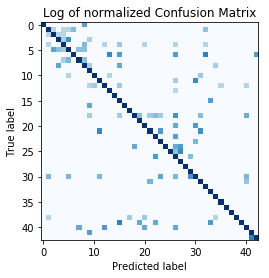

In [33]:
cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm = np.log(.0001 + cm)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Log of normalized Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

We observe some clusters in the confusion matrix above. It turns out that the various speed limits are sometimes misclassified among themselves. Similarly, traffic signs with traingular shape are misclassified among themselves. We can further improve on the model using hierarchical CNNs to first identify broader groups (like speed signs) and then have CNNs to classify finer features (such as the actual speed limit).

## Step 6: Testing the Model on New Images
In this step, we will use the model to predict traffic signs type of 5 random images of German traffic signs from the web our model's performance on these images.

In [34]:
# Loading and resizing new test images
new_test_images = []
path = './traffic-signs-data/new_test_images/'
for image in os.listdir(path):
    img = cv2.imread(path + image)
    img = cv2.resize(img, (32,32))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    new_test_images.append(img)
new_IDs = [13, 3, 14, 27, 17]
print("Number of new testing examples: ", len(new_test_images))

Number of new testing examples:  5


Displaying the new testing examples, with their respective ground-truth labels:

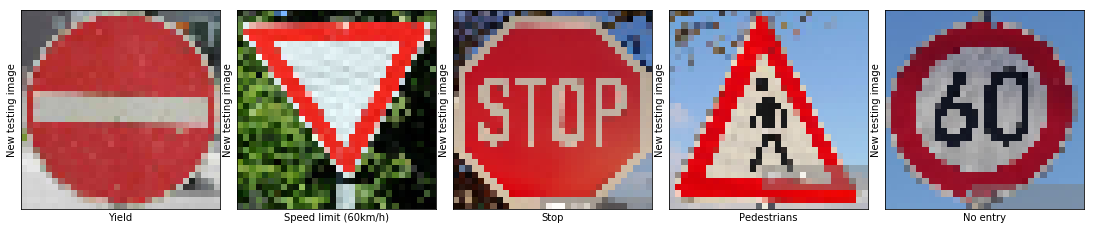

In [35]:
plt.figure(figsize=(15, 16))
for i in range(len(new_test_images)):
    plt.subplot(2, 5, i+1)
    plt.imshow(new_test_images[i])
    plt.xlabel(signs[new_IDs[i]])
    plt.ylabel("New testing image")
    plt.xticks([])
    plt.yticks([])
plt.tight_layout(pad=0, h_pad=0, w_pad=0)
plt.show()

These test images include some easy to predict signs, and other signs are considered hard for the model to predict.

For instance, we have easy to predict signs like the "Stop" and the "No entry". The two signs are clear and belong to classes where the model can predict with high accuracy.

On the other hand, we have signs belong to classes where has poor accuracy, like the "Speed limit" sign, because as stated above it turns out that the various speed limits are sometimes misclassified among themselves, and the "Pedestrians" sign, because traffic signs with traingular shape are misclassified among themselves.

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [38]:
# New test data preprocessing
new_test_images_preprocessed = preprocess(np.asarray(new_test_images))

INFO:tensorflow:Restoring parameters from Saved_Models/VGGNet
New Images Test Accuracy = 40.0%


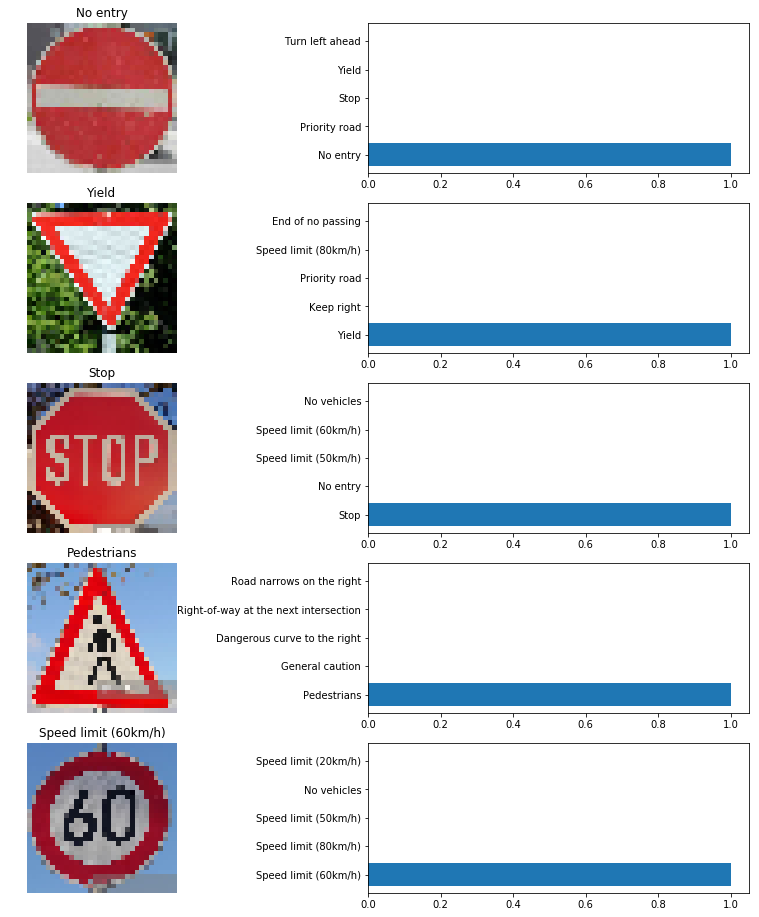

In [39]:
def y_predict_model(Input_data, top_k=5):
    """
    Generates the predictions of the model over the input data, and outputs the top softmax probabilities.
        Parameters:
            X_data: Input data.
            top_k (Default = 5): The number of top softmax probabilities to be generated.
    """
    num_examples = len(Input_data)
    y_pred = np.zeros((num_examples, top_k), dtype=np.int32)
    y_prob = np.zeros((num_examples, top_k))
    with tf.Session() as sess:
        VGGNet_Model.saver.restore(sess, os.path.join(DIR, "VGGNet"))
        y_prob, y_pred = sess.run(tf.nn.top_k(tf.nn.softmax(VGGNet_Model.logits), k=top_k), 
                             feed_dict={x:Input_data, keep_prob:1, keep_prob_conv:1})
    return y_prob, y_pred

y_prob, y_pred = y_predict_model(new_test_images_preprocessed)

test_accuracy = 0
for i in enumerate(new_test_images_preprocessed):
    accu = new_IDs[i[0]] == np.asarray(y_pred[i[0]])[0]
    if accu == True:
        test_accuracy += 0.2
print("New Images Test Accuracy = {:.1f}%".format(test_accuracy*100))

plt.figure(figsize=(15, 16))
new_test_images_len=len(new_test_images_preprocessed)
for i in range(new_test_images_len):
    plt.subplot(new_test_images_len, 2, 2*i+1)
    plt.imshow(new_test_images[i]) 
    plt.title(signs[y_pred[i][0]])
    plt.axis('off')
    plt.subplot(new_test_images_len, 2, 2*i+2)
    plt.barh(np.arange(1, 6, 1), y_prob[i, :])
    labels = [signs[j] for j in y_pred[i]]
    plt.yticks(np.arange(1, 6, 1), labels)
plt.show()

As we can notice from the top 5 softmax probabilities, the model has very high confidence when it comes to predicting signs, like the "Stop" and the "No entry" sign, and even high confidence when predicting simple triangular signs in relatively noisy images, like the "Yield". "Pedestrians", "Speed Limit(60km/h)" sign.  

The VGGNet model was able to predict the right class for each of the 5 new test images. Test Accuracy = 100.0%. In all cases, the model was very certain (80% - 100%) for the above the set of test images.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

## Conclusion  
Using VGGNet, we've been able to reach a very high accuracy rate. We can observe that the models saturate after nearly 10 epochs, so we can save some computational resources and reduce the number of epochs to 10. We can also try other preprocessing techniques to further improve the model's accuracy.. We can further improve on the model using hierarchical CNNs to first identify broader groups (like speed signs) and then have CNNs to classify finer features (such as the actual speed limit) This model will only work on input examples where the traffic signs are centered in the middle of the image. It doesn't have the capability to detect signs in the image corners.